In [1]:
import jax

jax.config.update("jax_enable_x64", True)

from functools import partial  # noqa: E402

import galsim  # noqa: E402
import jax.numpy as jnp  # noqa: E402
import matplotlib.pyplot as plt  # noqa: E402
import numpy as np  # noqa: E402

# Fit a Psuedo-Pade Approximation

## Define the Approximation and Fitting Range

In [2]:
# order of rational function in log(maxk_threshold), log(beta)
PADE_ORDERS = [9, 11]

N_PARAMS_MKTS = PADE_ORDERS[0] * 2 - 1
N_PARAMS_BETA = PADE_ORDERS[1] * 2 - 1
N_PARAMS = N_PARAMS_MKTS * N_PARAMS_BETA

LOG_BETA_MIN = np.log(1.1 + 1e-6)
LOG_BETA_MAX = np.log(100)
LOG_MKTS_MIN = np.log(1e-12)
LOG_MKTS_MAX = np.log(0.1)


def _pade_func(coeffs, x):
    order = (coeffs.shape[0] - 1) // 2
    p = jnp.polyval(coeffs[:order], x)
    q = jnp.polyval(
        jnp.concatenate([coeffs[order:], jnp.ones(1)], axis=0),
        x,
    )
    return p / q


@jax.jit
@partial(jax.vmap, in_axes=(0, 0, None))
def _logmaxk_psuedo_pade_approx(log_beta, log_mkts, coeffs):
    log_beta = (log_beta - LOG_BETA_MIN) / (LOG_BETA_MAX - LOG_BETA_MIN)
    log_mkts = (log_mkts - LOG_MKTS_MIN) / (LOG_MKTS_MAX - LOG_MKTS_MIN)
    coeffs = coeffs.reshape(N_PARAMS_MKTS, N_PARAMS_BETA)
    pqvals = jax.vmap(_pade_func, in_axes=(0, None))(coeffs, log_beta)
    return _pade_func(pqvals, log_mkts)

## Do the Fit

In [ ]:
n_beta = 50
n_mkts = 50


# this is the function we are interpolating
def _fun(beta, mkt):
    return galsim.Moffat(
        beta,
        scale_radius=1.0
    ).withGSParams(maxk_threshold=mkt).maxk


_betas = np.logspace(np.log10(np.exp(LOG_BETA_MIN)), np.log10(np.exp(LOG_BETA_MAX)), n_beta)
_mkts = np.logspace(np.log10(np.exp(LOG_MKTS_MIN)), np.log10(np.exp(LOG_MKTS_MAX)), n_mkts)

betas = []
mkts = []
maxks = []
for beta in _betas:
    for mkt in _mkts:
        betas.append(beta)
        mkts.append(mkt)
        maxks.append(
            _fun(beta, mkt)
        )
betas = jnp.array(betas)
mkts = jnp.array(mkts)
maxks = jnp.array(maxks)


@jax.jit
def _loss(coeffs, lnbetas, lnmaxk_thresholds, lnmaxks):
    pvals = _logmaxk_psuedo_pade_approx(lnbetas, lnmaxk_thresholds, coeffs)
    return jnp.mean((pvals - lnmaxks)**2)


_vag_loss = jax.jit(jax.value_and_grad(_loss))
_g_loss = jax.jit(jax.grad(_loss))
_h_loss = jax.jit(jax.hessian(_loss))

# generate an initial guess
coeffs = jnp.ones(N_PARAMS) * 1e-6

# args for loss
lnb = jnp.log(betas)
lnmkts = jnp.log(mkts)
lnmaxks = jnp.log(maxks)

In [ ]:
import jax.scipy.optimize as jspop
import optax
import tqdm


def _min_optax(
    fun,
    x0,
    args=None,
    maxiter=100_000,
    learning_rate=1e-1,
    method="adan",
    optimizer=None,
    opt_state=None,
    update_prog_iter=100,
):
    args = args or tuple()
    _vag_fun = jax.jit(jax.value_and_grad(fun))

    if optimizer is None:
        optimizer = getattr(optax, method)(learning_rate)
        opt_state = optimizer.init(x0)

        @jax.jit
        def _update_func(coeffs, opt_state):
            loss, grads = _vag_fun(coeffs, *args)
            updates, opt_state = optimizer.update(grads, opt_state, params=coeffs)
            coeffs = optax.apply_updates(coeffs, updates)
            return coeffs, opt_state, loss

    loss, _ = _vag_fun(x0, *args)

    prev_loss = None
    coeffs = x0

    with tqdm.trange(maxiter) as pbar:
        for i in pbar:
            coeffs, opt_state, loss = _update_func(coeffs, opt_state)

            if i % update_prog_iter == 0 or i == 0:
                if prev_loss is not None:
                    dloss = loss - prev_loss
                else:
                    dloss = np.nan

                pbar.set_description(f"{method}: {loss:12.8e} ({dloss:+9.2e} delta)")

                prev_loss = loss

    return coeffs, (optimizer, opt_state)


def _min_bfgs(
    fun,
    x0,
    args=None,
    maxiter=100,
):
    args = args or tuple()

    coeffs = x0
    prev_loss = None
    tol = 1e-16
    with tqdm.trange(maxiter) as pbar:
        for _ in pbar:
            res = jspop.minimize(
                fun,
                coeffs,
                method="BFGS",
                args=args,
                tol=tol,
                options={"maxiter": 10000, "gtol": tol, "line_search_maxiter": 40},
            )

            if np.all(coeffs == res.x):
                coeffs = coeffs * (1.0 + (np.random.uniform(size=coeffs.shape[0]) - 0.5) * 1e-10)
            else:
                coeffs = res.x

            if prev_loss is not None:
                dloss = res.fun - prev_loss
            else:
                dloss = np.nan

            prev_loss = res.fun

            pbar.set_description(
                f"bfgs: {res.fun:12.8e} ({dloss:+9.2e} delta, status {res.status}, nit {res.nit:6d})"
            )

    return res.x

In [5]:
args = (lnb, lnmkts, lnmaxks)

loss = _loss(coeffs, *args)
print(f"initial loss: {loss:12.8e}", flush=True)

for _ in range(10):
    # coeffs, _ = _min_optax(
    #     _loss,
    #     coeffs,
    #     args=args,
    #     learning_rate=1e-4,
    #     maxiter=100_000,
    #     update_prog_iter=1000,
    # )
    coeffs = _min_bfgs(
        _loss,
        coeffs,
        args=args,
        maxiter=100,
    )

initial loss: 1.14907850e+01


bfgs: 3.34256538e-09 (-1.36e-10 delta, status 3, nit   1056): 100%|██████████| 100/100 [03:20<00:00,  2.01s/it]
bfgs: 5.03995873e-10 (-2.06e-12 delta, status 3, nit    884): 100%|██████████| 100/100 [04:04<00:00,  2.45s/it]
bfgs: 2.19193005e-10 (-7.80e-13 delta, status 3, nit    703): 100%|██████████| 100/100 [04:48<00:00,  2.89s/it]
bfgs: 1.40302583e-10 (-2.99e-13 delta, status 3, nit   1001): 100%|██████████| 100/100 [04:19<00:00,  2.59s/it]
bfgs: 1.16155062e-10 (-2.78e-13 delta, status 3, nit    981): 100%|██████████| 100/100 [03:33<00:00,  2.14s/it]
bfgs: 1.05012548e-10 (-9.77e-23 delta, status 3, nit      2): 100%|██████████| 100/100 [02:42<00:00,  1.62s/it]
bfgs: 9.90393813e-11 (-7.43e-22 delta, status 3, nit      3): 100%|██████████| 100/100 [02:14<00:00,  1.34s/it]
bfgs: 9.29896973e-11 (-4.75e-22 delta, status 3, nit      2): 100%|██████████| 100/100 [02:11<00:00,  1.32s/it]
bfgs: 9.11488666e-11 (-6.50e-22 delta, status 3, nit      2): 100%|██████████| 100/100 [01:51<00:00,  1.

## Print the Coeffs

In [11]:
import textwrap

pstr = textwrap.indent(
    np.array2string(np.array(coeffs), floatmode="unique", threshold=100000000, separator=", ", max_line_width=120, sign="+"),
    "    ",
)

code_str = f"""\
# RATIONAL_POLY_VALS is the array of rational function
# polynomial coefficients that define the approximation
# fmt: off
RATIONAL_POLY_VALS = np.array(
{pstr},
    dtype=np.float64,
)
# fmt: on
"""

print(code_str)

exec(code_str)

# RATIONAL_POLY_VALS is the array of rational function
# polynomial coefficients that define the approximation
# fmt: off
RATIONAL_POLY_VALS = np.array(
    [+4.0377541235164999e-01, +9.8573979309710097e-02, -8.8368998636191423e-02, -1.4404058874465467e-01,
     -1.8722517103965541e-01, -2.3941575929900452e-01, +1.9477051520522798e-01, +2.5174893659382911e+00,
     +6.9802569884628065e+00, +2.9528987005934546e+00, -9.1832169346703629e-01, +4.9286238397646115e-01,
     +1.0005636301164393e+00, +7.0392335018807339e-01, -1.4054536940247431e-01, -8.5218622931551169e-01,
     -6.7621128905401928e-01, -2.9537613003541291e-01, -1.2854667245219107e+00, +4.0189909948806379e+00,
     +2.1850570724764290e-01, -4.2274342642823717e-02, -2.2450115304011090e-01, -3.6887180044787632e-01,
     -4.3603364254842064e-01, -4.9256905759091729e-01, -6.6398873219847576e-01, -5.9558712629992638e-01,
     +1.1837909921308221e+00, -4.6138529248538136e+00, +1.3450469324602885e+00, +4.9458187528754460e-01,
     +6

## Testing

maximum frac error: 0.0009469787500918647


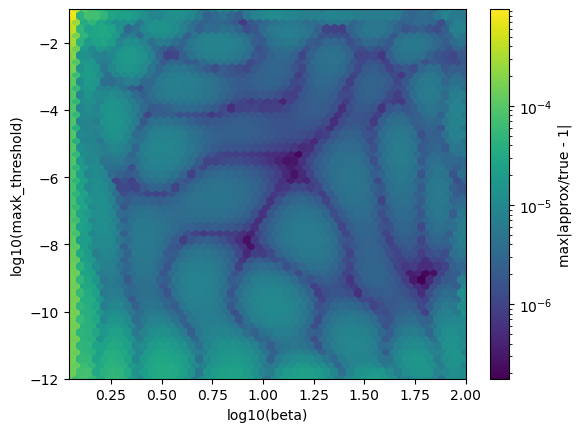

In [10]:
rng = np.random.default_rng()
n_test = 100000

tbetas = 10**rng.uniform(low=np.log10(1.1 + 1e-6), high=np.log10(100), size=n_test)
tmaxk_thresholds = 10**rng.uniform(low=-12, high=-1, size=n_test)
apprx = jnp.exp(_logmaxk_psuedo_pade_approx(jnp.log(tbetas), jnp.log(tmaxk_thresholds), RATIONAL_POLY_VALS))
true = np.array([
    _fun(tbetas[i], tmaxk_thresholds[i])
    for i in range(n_test)
])
eps = np.abs(apprx / true - 1)
c_func = np.max
eps_label = "max|approx/true - 1|"
print("maximum frac error:", c_func(eps))

fig, ax = plt.subplots()
hb = ax.hexbin(
    np.log10(tbetas),
    np.log10(tmaxk_thresholds),
    C=eps,
    reduce_C_function=c_func,
    extent=(np.log10(1.1), np.log10(100), -12, -1),
    gridsize=50,
    bins="log",
)
ax.set_xlim(np.log10(1.1), np.log10(100))
ax.set_ylim(-12, -1)
ax.set_xlabel("log10(beta)")
ax.set_ylabel("log10(maxk_threshold)")
fig.colorbar(hb, label=eps_label)

# Hacking and Testing Code Below

## Define Range of Interpolant and Spacings

In [ ]:
beta_min = 1.1 + 1e-6
beta_max = 100
n_beta = 100  # used to fit the rational function approx
mkts_min = 1e-12
mkts_max = 0.1
n_mkts = 100  # we build this many rational function approximations
RATNL_ORDER = 11

betas = np.logspace(np.log10(beta_min), np.log10(beta_max), n_beta)
mkts = np.logspace(jnp.log10(mkts_min), jnp.log10(mkts_max), n_mkts)

# this is the function we are interpolating
def _fun(beta, sr, mkt):
    return galsim.Moffat(
        beta,
        scale_radius=sr
    ).withGSParams(maxk_threshold=mkt).maxk

## Build rational function apprx. in beta at fixed maxk_threshold

In [ ]:
import scipy.optimize
import numpy.polynomial
from numpy.polynomial import Polynomial
import jax_galsim.core.interpolate

numpy.polynomial.set_default_printstyle("ascii")


def get_ratnl_func_polys(coeff):
    p_coeff = coeff[0 : RATNL_ORDER + 1]
    q_coeff = np.concatenate([[1], coeff[RATNL_ORDER + 1 :]])
    pm = Polynomial(p_coeff)
    qm = Polynomial(q_coeff)
    return pm, qm


def get_ratnl_func_coeffs(coeff):
    p_coeff = coeff[0 : RATNL_ORDER + 1]
    q_coeff = np.concatenate([[1], coeff[RATNL_ORDER + 1 :]])
    return p_coeff, q_coeff


def ratnl_func(x, *coeff):
    pm, qm = get_ratnl_func_polys(coeff)
    return pm(x) / qm(x)


def make_poly_code(pm, head="", base_indent=0):
    res = ""
    indent = base_indent
    for c in pm.coef:
        if c == pm.coef[-1]:
            end = ""
        else:
            end = " + x * ("

        if c == pm.coef[0]:
            _hd = head
        else:
            _hd = ""
        res += " " * 4 * indent + f"{_hd}{c}{end}\n"
        if c != pm.coef[-1]:
            indent += 1

    for _ in pm.coef[:-1]:
        indent -= 1
        res += " " * 4 * indent + ")\n"

    return res

In [ ]:
eps = 1e-6

poly_res = []

for mkt in mkts:
    vals = np.array([_fun(beta, 1.0, mkt) for beta in betas])

    res = scipy.optimize.curve_fit(
        ratnl_func,
        np.log(betas),
        np.log(vals),
        p0=np.ones(2 * RATNL_ORDER + 1),
        full_output=True,
        maxfev=100000,
        ftol=eps,
        xtol=eps,
    )

    coeff = res[0]

    pm, qm = get_ratnl_func_coeffs(coeff)

    poly_res.append((pm[::-1], qm[::-1]))

In [ ]:
import textwrap

pstr = textwrap.indent(
    np.array2string(np.array(poly_res), floatmode="unique", threshold=100000000, separator=", ", max_line_width=120, sign="+"),
    "    ",
)

In [ ]:
code = f"""\
# START OF GENERATED CODE
# The code in this block is generated by the notebook dev/notebooks/moffat_maxk_interp.ipynb.

MKTS_MIN = {mkts_min}
MKTS_MAX = {mkts_max}
N_MKTS = {n_mkts}
LOG_MKTS = np.log(np.logspace(jnp.log10(MKTS_MIN), jnp.log10(MKTS_MAX), N_MKTS))

# RATIONAL_POLY_VALS is an array of 7-th order ration function approximations
# for maxk as a function of log(beta) at fixed maxk_threshold values. the coeffs
# are stored from highest degree to lowest. The shape of the array is
# ({n_mkts}, 2, {RATNL_ORDER + 1}).
# fmt: off
RATIONAL_POLY_VALS = np.array(
{pstr},
    dtype=np.float64,
)
# fmt: on


@jax.jit
def _moffat_maxk(beta, maxk_threshold, r0):
    log_beta = jnp.log(beta)
    log_maxk_threshold = jnp.log(maxk_threshold)
    maxk_vals = jnp.array(
        [
            jnp.exp(
                jnp.polyval(RATIONAL_POLY_VALS[i, 0, :], log_beta)
                / jnp.polyval(RATIONAL_POLY_VALS[i, 1, :], log_beta)
            )
            for i in range(N_MKTS)
        ]
    )
    coeffs = akima_interp_coeffs(LOG_MKTS, maxk_vals)
    return akima_interp(log_maxk_threshold, LOG_MKTS, maxk_vals, coeffs) / r0


# END OF GENERATED CODE
"""

print(code)

## Testing

In [ ]:
from jax_galsim.core.interpolate import akima_interp, akima_interp_coeffs

exec(code)

In [ ]:
rng = np.random.default_rng(seed=10)
n_test = 100000

betas = rng.uniform(low=1.1 + 1e-6, high=100, size=n_test)
maxk_thresholds = 10**rng.uniform(low=-12, high=-1, size=n_test)
apprx = np.array([
    _moffat_maxk(betas[i], maxk_thresholds[i], 1.0)
    for i in range(n_test)
])
true = np.array([
    _fun(betas[i], 1.0, maxk_thresholds[i])
    for i in range(n_test)
])

# plt.hist(true / apprx - 1, bins=25, log=True)
# ax = plt.gca()
# ax.set_xlabel("fractional error in maxk approx.")
# ax.set_ylabel("# of points")

fig, ax = plt.subplots()
hb = ax.hexbin(
    betas,
    np.log10(maxk_thresholds),
    C=np.log10(np.abs(apprx-true)),
    extent=(1.1, 100, -12, -1),
    gridsize=50,
    vmin=-7,
    vmax=-2
)
ax.set_xlim(1.1, 100)
ax.set_ylim(-12, -1)
ax.set_xlabel("beta")
ax.set_ylabel("log10(maxk_threshold)")
fig.colorbar(hb, label="log10(|approx - true|)")

## Code to Minimize w/ SGD

In [ ]:
import optax
import tqdm

optimizer = None
learning_rate = 1e-5
opt_attr = "adan"

if optimizer is None:
    optimizer = getattr(optax, opt_attr)(learning_rate)
    opt_state = optimizer.init(coeffs)

    @jax.jit
    def _update_func(coeffs, opt_state):
        loss, grads = _vag_loss(coeffs, lnb, lnmkts, lnmaxks)
        updates, opt_state = optimizer.update(grads, opt_state, params=coeffs)
        coeffs = optax.apply_updates(coeffs, updates)
        return coeffs, opt_state, loss

lnb = jnp.log(betas)
lnmkts = jnp.log(mkts)
lnmaxks = jnp.log(maxks)

loss, _ = _vag_loss(coeffs, lnb, lnmkts, lnmaxks)
print("initial loss:", jnp.power(loss, 1.0 / lval), flush=True)

prev_loss = None
n_epoch = 200_000
ditr = 1000

with tqdm.trange(n_epoch) as pbar:
    for i in pbar:
        coeffs, opt_state, loss = _update_func(coeffs, opt_state)

        if i % ditr == 0:
            if prev_loss is not None:
                dloss = (jnp.power(loss, 1 / lval) - jnp.power(prev_loss, 1 / lval))
                pbar.set_description(f"loss: {jnp.power(loss, 1 / lval):10.4e} ({dloss:+9.2e} delta)")
            else:
                pbar.set_description(f"loss: {jnp.power(loss, 1 / lval):10.4e} (--------- delta)")

            prev_loss = loss

print(f"{i:04d}: {jnp.power(loss, 1 / lval):10.4e}", flush=True)

## Interpolation

In [ ]:
# this is the function we are interpolating
def _fun(beta, mkt):
    return galsim.Moffat(
        beta,
        scale_radius=1.0
    ).withGSParams(maxk_threshold=mkt).maxk


beta_min = 1.1 + 1e-6
beta_max = 100
n_beta = 500  # used to fit the rational function approx
mkts_min = 1e-12
mkts_max = 0.1
n_mkts = 200  # we build this many rational function approximations

_betas = np.logspace(np.log10(beta_min), np.log10(beta_max), n_beta)
_mkts = np.logspace(jnp.log10(mkts_min), jnp.log10(mkts_max), n_mkts)

betas = []
mkts = []
maxks = []
for beta in _betas:
    for mkt in _mkts:
        betas.append(beta)
        mkts.append(mkt)
        maxks.append(
            _fun(beta, mkt)
        )
betas = jnp.array(betas)
mkts = jnp.array(mkts)
maxks = jnp.array(maxks)

In [ ]:
import interpax

rng = np.random.default_rng()
n_test = 100000

tbetas = 10**rng.uniform(low=np.log10(1.1 + 1e-6), high=np.log10(100), size=n_test)
tmaxk_thresholds = 10**rng.uniform(low=-12, high=-1, size=n_test)
apprx = jnp.exp(
    interpax.interp2d(
        jnp.log(tbetas),
        jnp.log(tmaxk_thresholds),
        jnp.log(_betas),
        jnp.log(_mkts),
        jnp.log(maxks).reshape(n_beta, n_mkts),
        method="akima"
    )
)
true = np.array([
    _fun(tbetas[i], tmaxk_thresholds[i])
    for i in range(n_test)
])
eps = np.abs(apprx / true - 1)
c_func = np.max
eps_label = "max|approx/true - 1|"
print(c_func(eps))

msk = tmaxk_thresholds <= 0.03
print(c_func(eps[msk]))
# plt.hist(true / apprx - 1, bins=25, log=True)
# ax = plt.gca()
# ax.set_xlabel("fractional error in maxk approx.")
# ax.set_ylabel("# of points")

fig, ax = plt.subplots()
hb = ax.hexbin(
    np.log10(tbetas),
    np.log10(tmaxk_thresholds),
    C=eps,
    reduce_C_function=c_func,
    extent=(np.log10(1.1), np.log10(100), -12, -1),
    gridsize=50,
    bins="log",
)
ax.set_xlim(np.log10(1.1), np.log10(100))
ax.set_ylim(-12, -1)
ax.set_xlabel("log10(beta)")
ax.set_ylabel("log10(maxk_threshold)")
fig.colorbar(hb, label=eps_label)

## Symbolic Regression

In [ ]:
# this is the function we are interpolating
def _fun(beta, mkt):
    return galsim.Moffat(
        beta,
        scale_radius=1.0
    ).withGSParams(maxk_threshold=mkt).maxk


beta_min = 1.1 + 1e-6
beta_max = 100
n_beta = 50  # used to fit the rational function approx
mkts_min = 1e-12
mkts_max = 0.1
n_mkts = 50  # we build this many rational function approximations

_betas = np.logspace(np.log10(beta_min), np.log10(beta_max), n_beta)
_mkts = np.logspace(jnp.log10(mkts_min), jnp.log10(mkts_max), n_mkts)

betas = []
mkts = []
maxks = []
for beta in _betas:
    for mkt in _mkts:
        betas.append(beta)
        mkts.append(mkt)
        maxks.append(
            _fun(beta, mkt)
        )
betas = jnp.array(betas)
mkts = jnp.array(mkts)
maxks = jnp.array(maxks)


In [ ]:
from pysr import PySRRegressor

X = np.stack([np.log(betas), np.log(mkts)], axis=1)
y = np.log(maxks)

model = PySRRegressor(
    maxsize=50,
    niterations=100,
    binary_operators=["+", "*", "/", "^"],
    constraints={'^': (-1, 1)},
    elementwise_loss="loss(prediction, target) = abs(prediction - target)",
    model_selection='accuracy',
)

model.fit(X, y)

In [ ]:
rng = np.random.default_rng()
n_test = 100000

tbetas = 10**rng.uniform(low=np.log10(1.1 + 1e-6), high=np.log10(100), size=n_test)
tmaxk_thresholds = 10**rng.uniform(low=-12, high=-1, size=n_test)
tX = np.stack([np.log(tbetas), np.log(tmaxk_thresholds)], axis=1)

apprx = np.exp(model.predict(tX))
true = np.array([
    _fun(tbetas[i], tmaxk_thresholds[i])
    for i in range(n_test)
])
eps = np.abs(apprx / true - 1)
c_func = np.max
eps_label = "max|approx/true - 1|"
print(c_func(eps))

fig, ax = plt.subplots()
hb = ax.hexbin(
    np.log10(tbetas),
    np.log10(tmaxk_thresholds),
    C=eps,
    reduce_C_function=c_func,
    extent=(np.log10(1.1), np.log10(100), -12, -1),
    gridsize=50,
    bins="log",
)
ax.set_xlim(np.log10(1.1), np.log10(100))
ax.set_ylim(-12, -1)
ax.set_xlabel("log10(beta)")
ax.set_ylabel("log10(maxk_threshold)")
fig.colorbar(hb, label=eps_label)

In [ ]:
x = jnp.log(_betas * 1.01)
y = jnp.ones_like(x) * jnp.log(1e-4)
true = jnp.array([
    _fun(jnp.exp(x[i]), jnp.exp(y[i]))
    for i in range(x.shape[0])
])

approx = (
    interpax.interp2d(
        x,
        y,
        jnp.log(_betas),
        jnp.log(_mkts),
        jnp.log(maxks).reshape(n_beta, n_mkts),
        method="akima"
    )
)

plt.plot(
    x,
    approx,
)
plt.plot(
    x,
    jnp.log(true),
)

# plt.plot(x, jnp.log(true))

In [ ]:
interpax.interp2d?